In [1]:
import lightkurve

In [6]:
s2_file = lightkurve.search.open('./input/S02/tess-s0002-3-4_49.207_-58.524_25x25_astrocut.fits')
s3_file = lightkurve.search.open('./input/S03/tess-s0003-3-3_49.207_-58.524_25x25_astrocut.fits')
s4_file = lightkurve.search.open('./input/S04/tess-s0004-3-3_49.207_-58.524_25x25_astrocut.fits')
target_lc = s2_file.to_lightcurve().flatten()
target_lc = target_lc.append(s3_file.to_lightcurve().flatten())
target_lc = target_lc.append(s4_file.to_lightcurve().flatten())

target_lc = target_lc.remove_nans().remove_outliers()

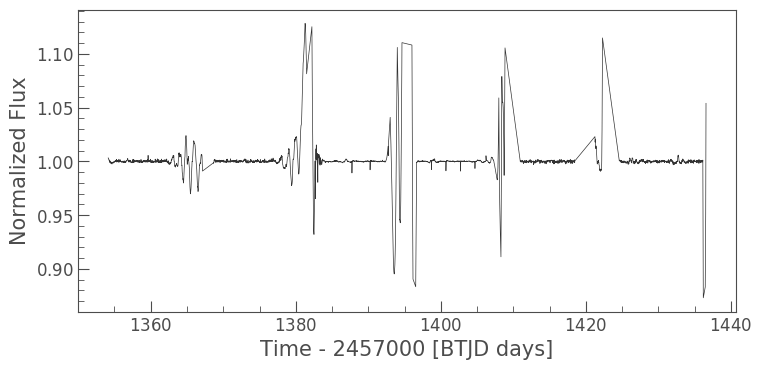

In [7]:
target_lc.plot()

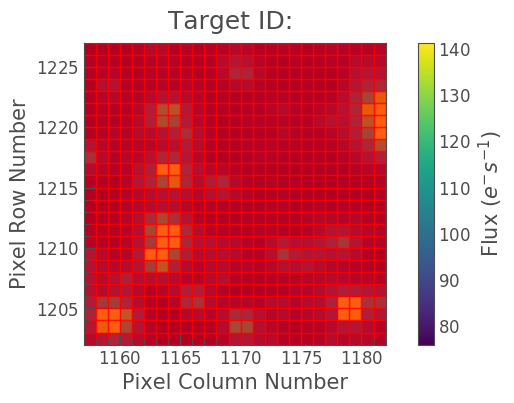

In [12]:
s2_file.plot(frame=100, aperture_mask=s2_file.pipeline_mask, mask_color='red')

In [13]:
import numpy as np

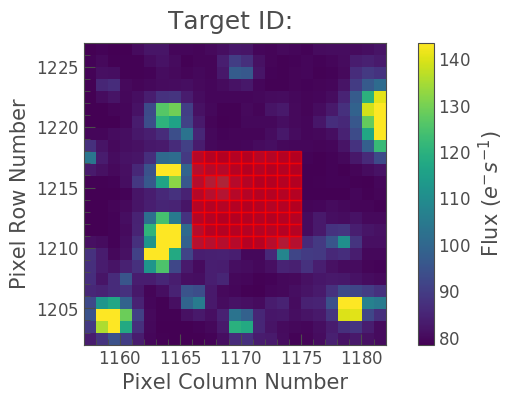

In [64]:
center_aperture = np.zeros(s2_file.shape[1:], dtype=np.int)
center_aperture[8:16,9:18] = 1
s2_file.plot(aperture_mask=center_aperture,mask_color='red')

In [68]:
center_lc = s2_file.to_lightcurve(aperture_mask=center_aperture.astype(bool)).flatten()
s2_lc = center_lc
s3_lc = (s3_file.to_lightcurve(aperture_mask=center_aperture.astype(bool)).flatten())
center_lc = center_lc.append(s3_lc)
s4_lc = (s4_file.to_lightcurve(aperture_mask=center_aperture.astype(bool)).flatten())
center_lc = center_lc.append(s4_lc)
center_lc.remove_nans().remove_outliers()

TessLightCurve(TICID: )

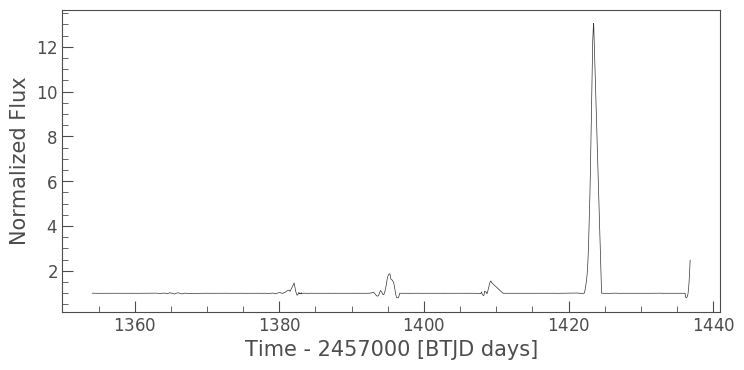

In [69]:
center_lc.plot()

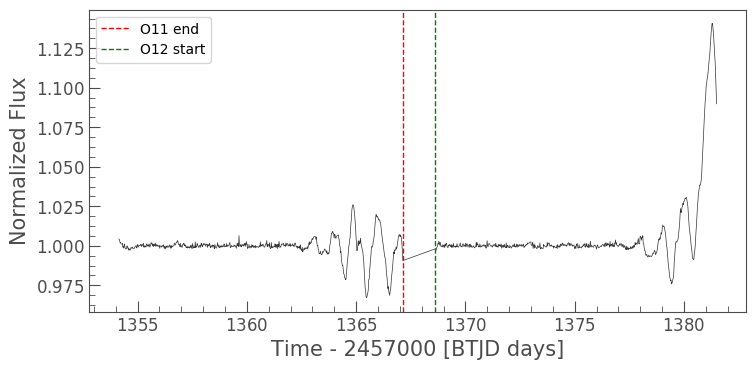

In [84]:
ax = s2_lc.plot()
ax.axvline(x=1367.15347, linestyle='--', linewidth=1, label='O11 end', color='red')
ax.axvline(x=1368.59406, linestyle='--', linewidth=1, label='O12 start', color='green')
ax.legend()

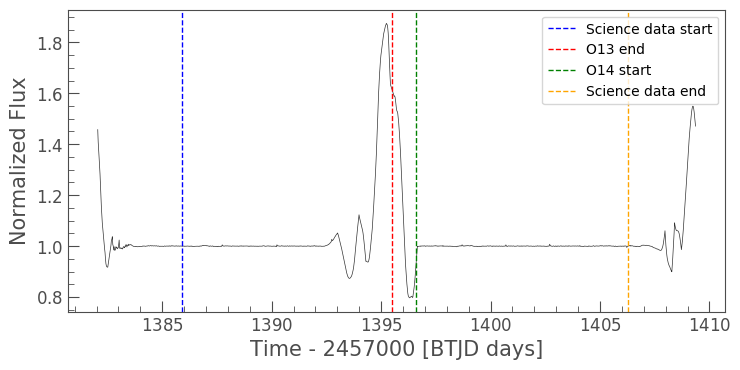

In [83]:
ax = s3_lc.plot()
ax.axvline(x=1385.89663, linestyle='--', linewidth=1, label='Science data start', color='blue')
ax.axvline(x=1395.47997, linestyle='--', linewidth=1, label='O13 end', color='red')
ax.axvline(x=1396.60497, linestyle='--', linewidth=1, label='O14 start', color='green')
ax.axvline(x=1406.29247, linestyle='--', linewidth=1, label='Science data end', color='orange')
ax.legend()

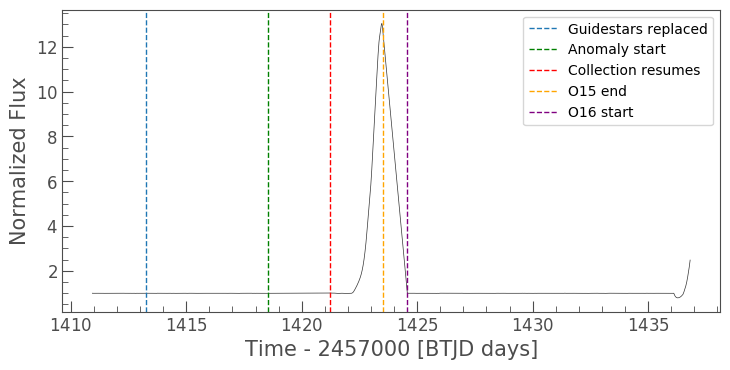

In [81]:
ax = s4_lc.plot()

ax.axvline(x=1413.26468, linestyle='--', linewidth=1, label='Guidestars replaced')
ax.axvline(x=1418.53691, linestyle='--', linewidth=1, label='Anomaly start', color='green')
ax.axvline(x=1421.21168, linestyle='--', linewidth=1, label='Collection resumes', color='red')
ax.axvline(x=1423.50890, linestyle='--', linewidth=1, label='O15 end', color='orange')
ax.axvline(x=1424.54897, linestyle='--', linewidth=1, label='O16 start', color='purple')
#ax.axvline(x=, linestyle='--', linewidth=1, label='', color='blue')
ax.legend()

From here: 
Since we're looking at an 'empty' little bit of sky here it seems like the right candidate for some pixel level lightcurve making and detrending. Probably should do a few things - 
1) Define the area to focus on (maybe not just the random box)
2) Make lightcurves for each pixel in area (include the nearby stars? they're pretty faint)
3) Make an ensemble from the lightcurves
4) Use the ensemble to detrend out the area in the middle
Also should probably do something smart about choosing pixels in the middle? Instead of just a random square?
--starting with S3 because the GRB event should happen during--

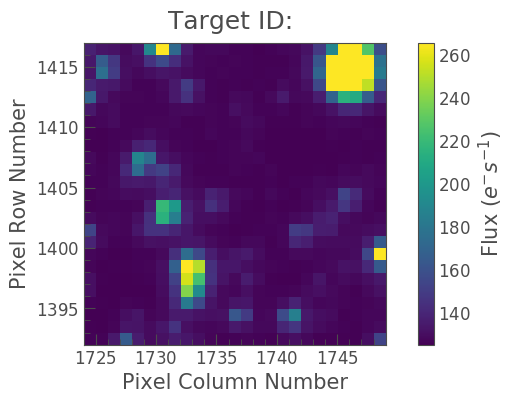

In [85]:
# GRB 180924A - Swift detection at 18-09-24 15:39 GMT
# TESS Sector3 - O13 start 18-09-20, 'data start' 18-09-24 09:30 UTC
# Should have ~6 hours (12 frames) of 'science quality' data prior to Swift observation
s3_file.plot()

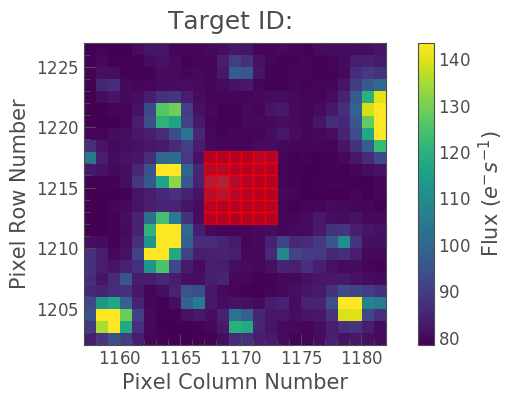

In [135]:
center_aperture = np.zeros(s3_file.shape[1:], dtype=np.int)
# NOTE: for future me - it's [Y,X) referencing, so 10:16 == [10,16), starting from bottom left
center_aperture[10:16,10:16] = 1 # is this big enough? 
s2_file.plot(aperture_mask=center_aperture,mask_color='red')

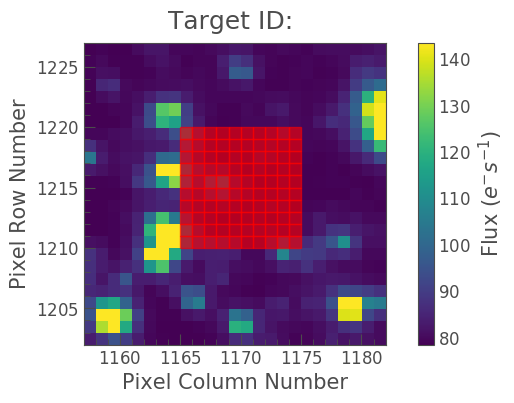

In [102]:
center_aperture = np.zeros(s3_file.shape[1:], dtype=np.int)
center_aperture[8:18,8:18] = 1 
s2_file.plot(aperture_mask=center_aperture,mask_color='red')
#this includes the edges of stars in the field; don't use for "target" LC, but okay for ensemble

In [145]:
# [8, 18) --> 10x10 px --> 100 LC's  ._.
# Remember: (8,18) == [Y, X)
LC_grid = np.empty([10,10], dtype=object)

yLC = 0
for y_ in range(8,18):
    xLC = 0
    for x_ in range(8,18):
        #starting in the bottom left-hand corner of the center_aperature
        pixel = np.zeros(s3_file.shape[1:], dtype=np.int)
        pixel[y_, x_] = 1
        LC_grid[yLC, xLC] = s3_file.to_lightcurve(aperture_mask=pixel.astype(bool)).flatten()
        xLC = xLC + 1 
    yLC = yLC + 1
        

In [147]:
import matplotlib.pyplot as plt

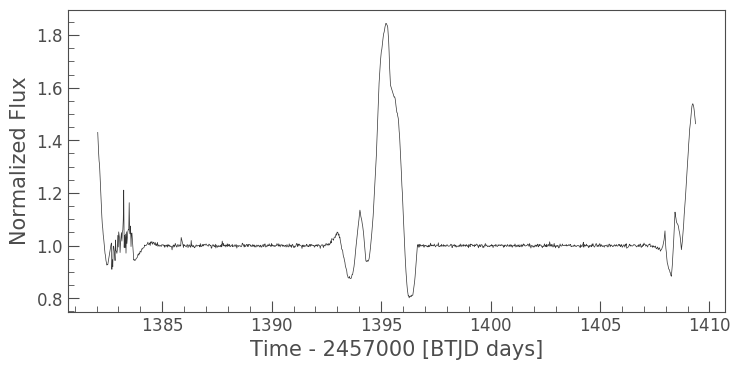

In [154]:
LC_grid[0,0].plot()

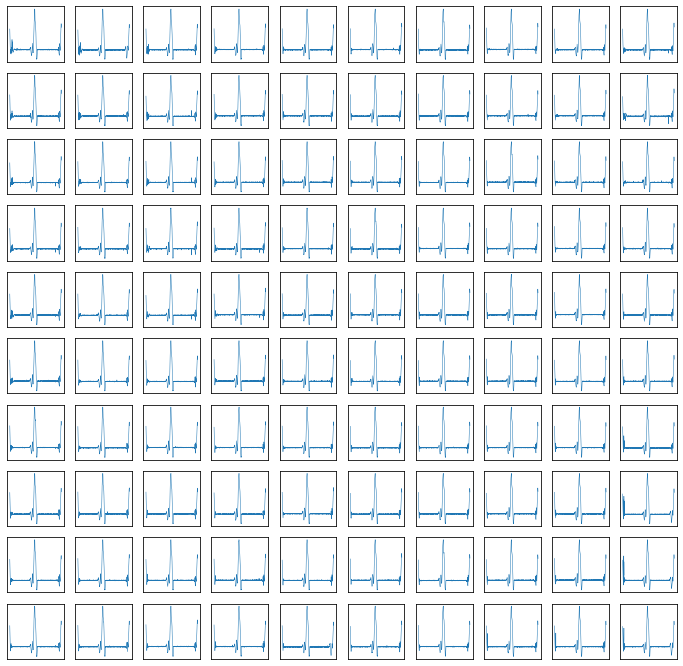

In [159]:
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(12, 12))
for yLC in range(0,10):
    for xLC in range(0,10):
        LC_grid[yLC,xLC].plot(ax=axs[yLC,xLC])
        axs[yLC,xLC].get_xaxis().set_visible(False)
        axs[yLC,xLC].get_yaxis().set_visible(False)

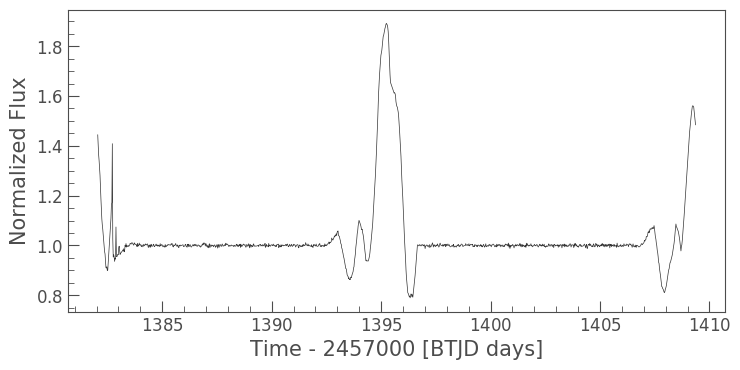

In [246]:
target_aperature = np.zeros(s3_file.shape[1:], dtype=np.int)
target_aperature[10:16,10:16] = 1
targetLC = s3_file.to_lightcurve(aperture_mask=pixel.astype(bool)).flatten()
targetLC.plot()

In [242]:
def fast_median(lc_ensemble):
        lc_medians = []
        col, row = np.asarray(lc_ensemble).shape
        for i in range(row):
            # find the median of the ensemble
            temp =[]
            for j in range(col):
                temp.append(lc_ensemble[j][i])
            lc_medians.append(np.median(temp))
        
        return lc_medians

In [243]:
# build the ensemble
def ensemble(inputLC):
    LC_ensemble = []
    mtarget = inputLC.flux - np.median(inputLC.flux)

    box = [[0,0],[0,4],[0,9],[4,0],[4,4],[4,9],[9,0],[9,4],[9,9]]

    for i in box:
        ens_flux = LC_grid[i[0], i[1]].flux
        LC_ensemble.append(ens_flux/np.median(ens_flux))

    lc_medians = np.asarray(fast_median(LC_ensemble))

    lc_corr = np.divide(inputLC.flux, lc_medians)
    lc_corr = np.divide(lc_corr, np.median(lc_corr))
    inputLC.flux = lc_corr * np.median(inputLC.flux)
    return inputLC


In [247]:
targetLC = ensemble(targetLC)
targetLC.flux = np.delete(targetLC.flux, np.where(targetLC.time>= 1406.29247), 0)
targetLC.time = np.delete(targetLC.time, np.where(targetLC.time>= 1406.29247), 0)
targetLC.flux = np.delete(targetLC.flux, np.where(targetLC.time<=1385.89663), 0)
targetLC.time = np.delete(targetLC.time, np.where(targetLC.time<=1385.89663), 0)

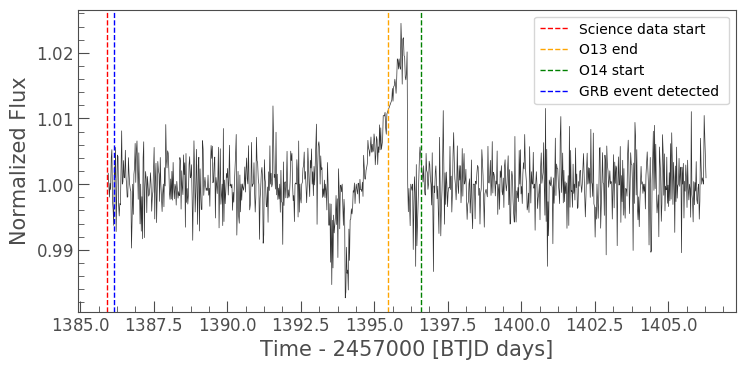

In [248]:

ax = targetLC.plot()

ax.axvline(x=1385.89663, linestyle='--', linewidth=1, label='Science data start', color='red')
ax.axvline(x=1395.47997, linestyle='--', linewidth=1, label='O13 end', color = 'orange')
ax.axvline(x=1396.60497, linestyle='--', linewidth=1, label='O14 start', color='green')

ax.axvline(x=1386.15235, linestyle='--', linewidth=1, label='GRB event detected ', color='blue')
ax.legend()

In [219]:
len(targetLC.flux)

954